In [15]:
import numpy as np
import pandas as pd
from pathlib import Path
# import pathlib.Path
import os.path
from os import path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [2]:
image_dir = Path('/kaggle/input/marvel-heroes/marvel')

In [3]:
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name = 'Label')

image_df = pd.concat([filepaths, labels], axis = 1)
image_df

,Filepath,Label
0,/kaggle/input/marvel-heroes/marvel/marvel/vali...,loki
1,/kaggle/input/marvel-heroes/marvel/marvel/vali...,loki
2,/kaggle/input/marvel-heroes/marvel/marvel/vali...,loki
3,/kaggle/input/marvel-heroes/marvel/marvel/vali...,loki
4,/kaggle/input/marvel-heroes/marvel/marvel/vali...,loki
...,...,...
6065,/kaggle/input/marvel-heroes/marvel/train/docto...,doctor strange
6066,/kaggle/input/marvel-heroes/marvel/train/docto...,doctor strange
6067,/kaggle/input/marvel-heroes/marvel/train/docto...,doctor strange
6068,/kaggle/input/marvel-heroes/marvel/train/docto...,doctor strange


In [4]:
image_df['Label'].value_counts()

doctor strange     812
spider-man         766
captain america    762
thanos             756
hulk               754
black widow        750
ironman            748
loki               722
Name: Label, dtype: int64

In [5]:
samples = []
for category in image_df['Label'].unique():
    category_slice = image_df.query("Label == @category")
    samples.append(category_slice.sample(200, random_state = 1))
image_df = pd.concat(samples, axis = 0).sample(frac = 1.0, random_state = 1).reset_index(drop=True)

image_df['Label'].value_counts()

loki               200
ironman            200
black widow        200
doctor strange     200
spider-man         200
captain america    200
hulk               200
thanos             200
Name: Label, dtype: int64

In [6]:
image_df

,Filepath,Label
0,/kaggle/input/marvel-heroes/marvel/marvel/trai...,loki
1,/kaggle/input/marvel-heroes/marvel/marvel/trai...,ironman
2,/kaggle/input/marvel-heroes/marvel/train/black...,black widow
3,/kaggle/input/marvel-heroes/marvel/marvel/trai...,ironman
4,/kaggle/input/marvel-heroes/marvel/train/docto...,doctor strange
...,...,...
1595,/kaggle/input/marvel-heroes/marvel/train/thano...,thanos
1596,/kaggle/input/marvel-heroes/marvel/marvel/trai...,hulk
1597,/kaggle/input/marvel-heroes/marvel/train/spide...,spider-man
1598,/kaggle/input/marvel-heroes/marvel/marvel/trai...,captain america


In [8]:
train_df, test_df = train_test_split(image_df, train_size = 0.7, shuffle = True, random_state = 1)

In [10]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input,
#     rescale=1./255,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input,
#     rescale=1./255
)



In [11]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    # color_mode='grayscale',
    color_mode = 'rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
#     color_mode='grayscale',
    color_mode = 'rgb',
#     class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
#     target_size=(28, 28),
    target_size=(224, 224),
#     color_mode='grayscale'
    color_mode = 'rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)


Found 896 validated image filenames belonging to 8 classes.
Found 224 validated image filenames belonging to 8 classes.
Found 480 validated image filenames belonging to 8 classes.


In [12]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape = (224, 224, 3),
    include_top = False,
    weights = "imagenet",
    pooling = 'avg'
)
pretrained_model.trainable = False

2022-12-19 04:45:47.076876: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 04:45:47.077777: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 04:45:47.245600: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 04:45:47.246426: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 04:45:47.247263: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

9420800/9406464 [==============================] - 0s 0us/step


In [13]:
inputs = pretrained_model.input
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(8, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

2022-12-19 04:47:50.444737: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-12-19 04:47:54.758286: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


28/28 [==============================] - 34s 824ms/step - loss: 1.6959 - accuracy: 0.3884 - val_loss: 1.4170 - val_accuracy: 0.5089
Epoch 2/100
28/28 [==============================] - 18s 638ms/step - loss: 0.9548 - accuracy: 0.7020 - val_loss: 1.3016 - val_accuracy: 0.5580
Epoch 3/100
28/28 [==============================] - 17s 600ms/step - loss: 0.6406 - accuracy: 0.8270 - val_loss: 1.2123 - val_accuracy: 0.6027
Epoch 4/100
28/28 [==============================] - 18s 631ms/step - loss: 0.3853 - accuracy: 0.9051 - val_loss: 1.1863 - val_accuracy: 0.6161
Epoch 5/100
28/28 [==============================] - 17s 614ms/step - loss: 0.2661 - accuracy: 0.9464 - val_loss: 1.2329 - val_accuracy: 0.6071
Epoch 6/100
28/28 [==============================] - 17s 622ms/step - loss: 0.1832 - accuracy: 0.9598 - val_loss: 1.2888 - val_accuracy: 0.6250
Epoch 7/100
28/28 [==============================] - 17s 622ms/step - loss: 0.1385 - accuracy: 0.9799 - val_loss: 1.3827 - val_accuracy: 0.6161


Test Accuracy: 62.92%


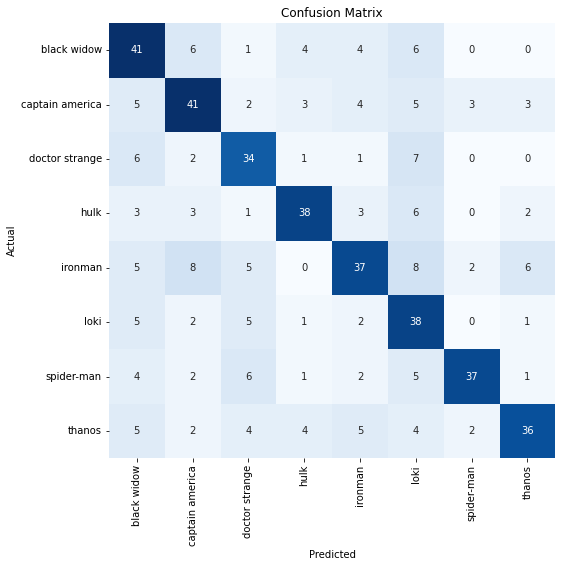

Classification Report:
----------------------
                  precision    recall  f1-score   support

    black widow       0.55      0.66      0.60        62
captain america       0.62      0.62      0.62        66
 doctor strange       0.59      0.67      0.62        51
           hulk       0.73      0.68      0.70        56
        ironman       0.64      0.52      0.57        71
           loki       0.48      0.70      0.57        54
     spider-man       0.84      0.64      0.73        58
         thanos       0.73      0.58      0.65        62

       accuracy                           0.63       480
      macro avg       0.65      0.63      0.63       480
   weighted avg       0.65      0.63      0.63       480



In [16]:
results = model.evaluate(test_images, verbose=0)
predictions = np.argmax(model.predict(test_images), axis=1)

class_names = list(test_images.class_indices.keys())

cm = confusion_matrix(test_images.labels, predictions, labels=np.arange(8))
clr = classification_report(test_images.labels, predictions, labels=np.arange(8), target_names=class_names)

print("Test Accuracy: {:.2f}%".format(results[1] * 100))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(8) + 0.5, labels=class_names, rotation=90)
plt.yticks(ticks=np.arange(8) + 0.5, labels=class_names, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)